### Defining Imports and Basic Setup

In [1]:
!pip -q install ./python
!python -m pip install pyvirtualdisplay
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0  10461      0 --:--:-- --:--:-- --:--:-- 12842


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from Agent import agent
from pyvirtualdisplay import Display
from workspace_utils import active_session

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

INFO:pyvirtualdisplay.abstractdisplay:Successfully started X with display ":1001".


### Initialize the environment

In [4]:
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Defining Hyperparameters

In [6]:
hyp = {'eps_start' : 1.0,         # starting value of epsilon, for epsilon-greedy action selection
       'eps_end' : 0.01,          # minimum value of epsilon
       'eps_decay' : 0.995,       # epsilon decay factor
       'buffer_size' : int(1e5),  # replay buffer size
       'batch_size' : 64,         # minibatch size
       'gamma' : 0.99,            # discount factor
       'tau' : 1e-3,              # for soft update of target parameters
       'lr' : 5e-4,               # learning rate 
       'update_every' : 4,        # how often to update the network
       'n_fc_layers': 5}          # Number of fully connected layers in the model

In [7]:
n_episodes = 2000 # maximum number of training episodes
max_t = 1000      # maximum number of timesteps per episode

### Initialize the agent

In [8]:
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_sample = env_info.vector_observations[0]
state_size = len(state_sample)
agent = agent(state_size, action_size, hyp, seed=27)

### Train agent function

In [9]:
def train_dqn_agent(n_episodes, max_t, hyperparameters):
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = hyperparameters['eps_start']
    threshold = 13.0
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        mean_score = np.mean(scores_window)
        eps = max(hyperparameters['eps_end'],eps*hyperparameters['eps_decay'])
        print(f'\rEpisode {i_episode:d}\tAverage Score: {mean_score:.2f}')
        if mean_score > threshold:
            print(f'\rEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {mean_score:.2f}')
            torch.save(agent.network_local.state_dict(),f'checkpoint_{threshold}_{i_episode-100:d}.pth')
            threshold += 0.5
             
    return scores

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}!')

Training on cuda:0!


### Training the agent and plotting the result

Episode 1	Average Score: 0.00
Episode 2	Average Score: 0.50
Episode 3	Average Score: 0.00
Episode 4	Average Score: -0.25
Episode 5	Average Score: -0.20
Episode 6	Average Score: -0.33
Episode 7	Average Score: -0.29
Episode 8	Average Score: -0.38
Episode 9	Average Score: -0.22
Episode 10	Average Score: -0.20
Episode 11	Average Score: -0.18
Episode 12	Average Score: -0.25
Episode 13	Average Score: -0.31
Episode 14	Average Score: -0.43
Episode 15	Average Score: -0.47
Episode 16	Average Score: -0.44
Episode 17	Average Score: -0.35
Episode 18	Average Score: -0.33
Episode 19	Average Score: -0.37
Episode 20	Average Score: -0.35
Episode 21	Average Score: -0.24
Episode 22	Average Score: -0.27
Episode 23	Average Score: -0.30
Episode 24	Average Score: -0.29
Episode 25	Average Score: -0.20
Episode 26	Average Score: -0.23
Episode 27	Average Score: -0.22
Episode 28	Average Score: -0.29
Episode 29	Average Score: -0.24
Episode 30	Average Score: -0.20
Episode 31	Average Score: -0.23
Episode 32	Average S

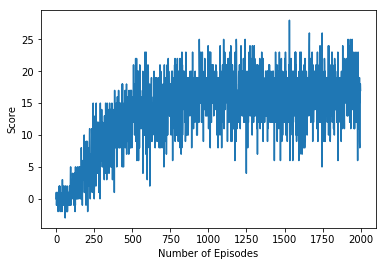

In [11]:
%%time
with active_session():
    scores = train_dqn_agent(n_episodes, max_t, hyp)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)),scores)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Score')
    plt.show

In [12]:
env.close()